## Get the Data

In [1]:
import pandas as pd

df = pd.read_csv("../Data/cleaned_dataset.csv")
df

,Mean Temperature,Mean Pressure,Rainfall,Relative Humidity,Mean Cloud,Evaporation,Global Solar Radiation,Max UV,Wind Speed,Mean UV,...,RSP,O3,FSP,Intensity,Signal,Duration(hr min),day_sin,day_cos,wind_sin,wind_cos
0,15.4,1025.1,0.00,68.0,57.0,3.4,18.11,10.072187,6.730814,4.592663,...,43.0,0.0,31.0,0.0,0.0,0.0,0.999991,0.004304,0.173648,0.984808
1,16.6,1025.8,0.00,69.0,79.0,3.1,12.94,9.279723,8.470005,3.780165,...,57.0,0.0,37.0,0.0,0.0,0.0,0.999917,-0.012910,0.173648,0.984808
2,17.5,1023.0,0.00,69.0,53.0,4.0,20.32,10.851292,6.246643,5.183114,...,51.0,0.0,37.0,0.0,0.0,0.0,0.999546,-0.030120,0.173648,0.984808
3,18.5,1018.7,0.00,78.0,89.0,2.8,12.21,11.371977,10.663324,4.197858,...,53.0,-0.0,33.0,0.0,0.0,0.0,0.998880,-0.047321,0.342020,0.939693
4,19.7,1014.7,0.05,85.0,90.0,1.6,11.50,10.239657,11.126056,3.814848,...,54.0,-0.0,33.0,0.0,0.0,0.0,0.997917,-0.064508,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12157,27.3,1009.3,0.05,73.0,77.0,3.1,9.52,4.000000,12.200000,2.000000,...,24.0,65.0,18.0,0.0,0.0,0.0,-0.891981,0.452072,0.984808,-0.173648
12158,25.8,1010.1,0.05,67.0,83.0,3.0,6.97,4.000000,9.700000,2.000000,...,16.0,28.0,11.0,0.0,0.0,0.0,-0.884068,0.467359,0.500000,0.866025
12159,25.3,1011.1,0.05,69.0,86.0,3.0,9.41,6.000000,8.400000,2.000000,...,19.0,31.0,14.0,0.0,0.0,0.0,-0.875892,0.482508,0.500000,0.866025
12160,26.2,1010.3,0.00,64.0,70.0,5.0,18.57,7.000000,8.300000,3.000000,...,28.0,36.0,20.0,0.0,0.0,0.0,-0.867456,0.497513,0.500000,0.866025


## Environment Setup

In [2]:

## RNN

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import random
import warnings
from torch.utils.data import DataLoader
from tqdm import tqdm
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data processing

In [3]:
target_cols = "Mean Temperature"
feautures_cols = [col for col in df.columns if col != target_cols]

target = df[target_cols].values
feature = df[feautures_cols].values

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()


target_scaled = scaler_target.fit_transform(target.reshape(-1, 1))
features_scaled = scaler_features.fit_transform(feature)

combined_features = np.concatenate([features_scaled, target_scaled], axis=1)

In [4]:
sequence_length = 30
def create_dataset(data, target, seq_length=1):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

X, y = create_dataset(combined_features, target_scaled, sequence_length)
X = torch.tensor(X, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Model

In [ ]:
class EnhancedRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(EnhancedRNNModel, self).__init__()

        # LSTM instead of RNN
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5, device='cpu'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')  # Track best validation loss
    patience_counter = 0  # Count epochs without improvement

    # Wrap the epoch loop with tqdm for a progress bar
    epoch_bar = tqdm(range(num_epochs), desc="Training Progress", unit="epoch")
    for epoch in epoch_bar:
        model.train()
        running_loss = 0.0
        for features, targets in train_loader:
            features, targets = features.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for features, targets in val_loader:
                features, targets = features.to(device), targets.to(device)
                outputs = model(features)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item()

        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        # Update epoch progress bar with current losses
        epoch_bar.set_postfix({"Train Loss": f"{train_loss:.4f}", "Val Loss": f"{val_loss:.4f}"})

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0  # Reset counter if validation loss improves
            # Save the best model
            torch.save(model.state_dict(), 'best_lstm_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                epoch_bar.write(f"Early stopping triggered after {epoch+1} epochs (no improvement for {patience} epochs).")
                # Load the best model state before exiting
                model.load_state_dict(torch.load('best_lstm_model.pth'))
                break

    # Plot training and validation loss
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('RNN Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    return train_losses, val_losses

In [8]:
def evaluate_model(model, test_loader, scaler_target, device='cpu'):
    # Ensure model is on the correct device
    model.to(device)
    model.eval()
    predictions = []
    actuals = []

    # Collect predictions and actuals
    with torch.no_grad():
        for features, targets in test_loader:
            features, targets = features.to(device), targets.to(device)
            outputs = model(features)
            predictions.append(outputs.cpu().numpy())
            actuals.append(targets.cpu().numpy())

    # Concatenate
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Debugging: Print first 5 scaled predictions
    print("First 5 scaled predictions:", predictions[:5].flatten())

    # Inverse transform
    predictions = scaler_target.inverse_transform(predictions)
    actuals = scaler_target.inverse_transform(actuals)

    # Debugging: Print first 5 inverse-transformed predictions
    print("First 5 inverse-transformed predictions:", predictions[:5].flatten())

    return predictions, actuals

In [9]:
import os

def plot_performance(train_losses, val_losses, predictions, actuals, title = 'LSTM Model Performance'):
    plt.figure(figsize=(12, 10))

    plt.subplot(3, 1, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(actuals, label='Actual', color='blue')
    plt.plot(predictions, label='Predicted', color='red')
    plt.title('LSTM Model Predictions vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Mean Temperature')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(actuals[-100:], label='Actual', color='blue')
    plt.plot(predictions[-100:], label='Predicted', color='red')
    plt.title('Zoomed-in LSTM Model Predictions vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Mean Temperature')
    plt.legend()

    plt.suptitle(title)

    path = 'results/'
    if not os.path.exists(path):
        os.makedirs(path)

    plt.savefig(path + title.replace(" ", "_") + '.png')
    plt.close()


In [10]:
def calculate_metrics(predictions, actuals):
    mse = mean_squared_error(actuals, predictions)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)

    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    return rmse, mae

## Check the best parameter

Training with Seq: 10, Hidden: 32, Layers: 1, LR: 0.001


Training Progress:  40%|████      | 40/100 [00:18<00:28,  2.11epoch/s, Train Loss=0.0019, Val Loss=0.0021]


Early stopping triggered after 41 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.47540733 0.51958656 0.3120417  0.4293196  0.46442673]
First 5 inverse-transformed predictions: [17.973701 19.188631 13.481147 16.706287 17.671734]
RMSE: 1.2408
MAE: 0.9735
RMSE: 1.2408404453877357, MAE: 0.973509669303894
--------------------------------------------------
Training with Seq: 10, Hidden: 32, Layers: 2, LR: 0.001


Training Progress:  22%|██▏       | 22/100 [00:11<00:40,  1.94epoch/s, Train Loss=0.0020, Val Loss=0.0030]


Early stopping triggered after 23 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46942872 0.5228743  0.29767913 0.42557788 0.4814271 ]
First 5 inverse-transformed predictions: [17.80929  19.279043 13.086176 16.603392 18.139244]
RMSE: 1.3079
MAE: 1.0481
RMSE: 1.307852737372908, MAE: 1.0480624437332153
--------------------------------------------------
Training with Seq: 10, Hidden: 32, Layers: 3, LR: 0.001


Training Progress:  46%|████▌     | 46/100 [00:25<00:29,  1.83epoch/s, Train Loss=0.0018, Val Loss=0.0026]


Early stopping triggered after 47 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.47245103 0.5387258  0.2860859  0.4461155  0.4591577 ]
First 5 inverse-transformed predictions: [17.892403 19.71496  12.767363 17.168177 17.526836]
RMSE: 1.1543
MAE: 0.8788
RMSE: 1.1543063245667302, MAE: 0.8787696957588196
--------------------------------------------------
Training with Seq: 10, Hidden: 64, Layers: 1, LR: 0.001


Training Progress:  38%|███▊      | 38/100 [00:17<00:28,  2.15epoch/s, Train Loss=0.0020, Val Loss=0.0025]


Early stopping triggered after 39 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.47036532 0.5257788  0.30724338 0.43323925 0.48502085]
First 5 inverse-transformed predictions: [17.835045 19.358917 13.349194 16.81408  18.238073]
RMSE: 1.2282
MAE: 0.9381
RMSE: 1.228225649526497, MAE: 0.938064694404602
--------------------------------------------------
Training with Seq: 10, Hidden: 64, Layers: 2, LR: 0.001


Training Progress:  24%|██▍       | 24/100 [00:12<00:38,  2.00epoch/s, Train Loss=0.0020, Val Loss=0.0024]


Early stopping triggered after 25 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.45727047 0.51760983 0.31068656 0.41868225 0.46239302]
First 5 inverse-transformed predictions: [17.474937 19.134272 13.443881 16.413761 17.615807]
RMSE: 1.2819
MAE: 0.9954
RMSE: 1.2818500230309686, MAE: 0.9954469203948975
--------------------------------------------------
Training with Seq: 10, Hidden: 64, Layers: 3, LR: 0.001


Training Progress:  34%|███▍      | 34/100 [00:18<00:35,  1.85epoch/s, Train Loss=0.0020, Val Loss=0.0022]


Early stopping triggered after 35 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.47128466 0.51199514 0.28229827 0.41118678 0.44711468]
First 5 inverse-transformed predictions: [17.860327 18.979866 12.663202 16.207636 17.195654]
RMSE: 1.3574
MAE: 1.0844
RMSE: 1.3573659761843588, MAE: 1.0843758583068848
--------------------------------------------------
Training with Seq: 10, Hidden: 128, Layers: 1, LR: 0.001


Training Progress:  73%|███████▎  | 73/100 [00:33<00:12,  2.18epoch/s, Train Loss=0.0019, Val Loss=0.0020]


Early stopping triggered after 74 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.4789459  0.5299501  0.32046908 0.43703097 0.47990125]
First 5 inverse-transformed predictions: [18.071012 19.473627 13.7129   16.918352 18.097284]
RMSE: 1.1860
MAE: 0.9034
RMSE: 1.1859667064503092, MAE: 0.9034042954444885
--------------------------------------------------
Training with Seq: 10, Hidden: 128, Layers: 2, LR: 0.001


Training Progress:  23%|██▎       | 23/100 [00:11<00:38,  1.98epoch/s, Train Loss=0.0020, Val Loss=0.0023]


Early stopping triggered after 24 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.48943216 0.5108561  0.3111756  0.4099887  0.47055858]
First 5 inverse-transformed predictions: [18.359385 18.948544 13.45733  16.17469  17.84036 ]
RMSE: 1.3489
MAE: 1.0832
RMSE: 1.3488846639697591, MAE: 1.0831634998321533
--------------------------------------------------
Training with Seq: 10, Hidden: 128, Layers: 3, LR: 0.001


Training Progress:  19%|█▉        | 19/100 [00:10<00:45,  1.80epoch/s, Train Loss=0.0021, Val Loss=0.0031]


Early stopping triggered after 20 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.45357382 0.52130276 0.30958128 0.45131016 0.4790892 ]
First 5 inverse-transformed predictions: [17.37328  19.235826 13.413486 17.31103  18.074953]
RMSE: 1.3589
MAE: 1.0846
RMSE: 1.3588963685428124, MAE: 1.0845717191696167
--------------------------------------------------
Training with Seq: 10, Hidden: 256, Layers: 1, LR: 0.001


Training Progress:  36%|███▌      | 36/100 [00:16<00:29,  2.14epoch/s, Train Loss=0.0020, Val Loss=0.0023]


Early stopping triggered after 37 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.47768474 0.51624036 0.32042813 0.41488692 0.47368637]
First 5 inverse-transformed predictions: [18.036331 19.096611 13.711774 16.30939  17.926374]
RMSE: 1.3148
MAE: 1.0606
RMSE: 1.3147621188376832, MAE: 1.0605946779251099
--------------------------------------------------
Training with Seq: 10, Hidden: 256, Layers: 2, LR: 0.001


Training Progress:  33%|███▎      | 33/100 [00:17<00:34,  1.94epoch/s, Train Loss=0.0021, Val Loss=0.0024]


Early stopping triggered after 34 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.4746856  0.511216   0.2980816  0.4447953  0.48548955]
First 5 inverse-transformed predictions: [17.953854 18.958439 13.097244 17.131872 18.250963]
RMSE: 1.2592
MAE: 0.9840
RMSE: 1.259242648607811, MAE: 0.9839566349983215
--------------------------------------------------
Training with Seq: 10, Hidden: 256, Layers: 3, LR: 0.001


Training Progress:  41%|████      | 41/100 [00:22<00:32,  1.81epoch/s, Train Loss=0.0078, Val Loss=0.0065]


Early stopping triggered after 42 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.47473246 0.52077883 0.30991077 0.41164786 0.46237856]
First 5 inverse-transformed predictions: [17.955143 19.221418 13.422546 16.220316 17.61541 ]
RMSE: 1.2524
MAE: 0.9725
RMSE: 1.2524312217848586, MAE: 0.9725311398506165
--------------------------------------------------
Training with Seq: 20, Hidden: 32, Layers: 1, LR: 0.001


Training Progress:  34%|███▍      | 34/100 [00:15<00:30,  2.16epoch/s, Train Loss=0.0019, Val Loss=0.0021]


Early stopping triggered after 35 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.30168185 0.41371632 0.47255602 0.5161145  0.56665194]
First 5 inverse-transformed predictions: [13.196251 16.277199 17.89529  19.09315  20.48293 ]
RMSE: 1.2746
MAE: 1.0047
RMSE: 1.2746362952786567, MAE: 1.0047118663787842
--------------------------------------------------
Training with Seq: 20, Hidden: 32, Layers: 2, LR: 0.001


Training Progress:  24%|██▍       | 24/100 [00:12<00:38,  1.95epoch/s, Train Loss=0.0020, Val Loss=0.0025]


Early stopping triggered after 25 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.3152395  0.40863714 0.4865007  0.50158143 0.56446713]
First 5 inverse-transformed predictions: [13.569086 16.13752  18.278769 18.69349  20.422846]
RMSE: 1.3158
MAE: 1.0598
RMSE: 1.315809799589469, MAE: 1.0598294734954834
--------------------------------------------------
Training with Seq: 20, Hidden: 32, Layers: 3, LR: 0.001


Training Progress:  34%|███▍      | 34/100 [00:19<00:36,  1.79epoch/s, Train Loss=0.0020, Val Loss=0.0025]


Early stopping triggered after 35 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.2793039  0.4222846  0.46707076 0.5124482  0.5585869 ]
First 5 inverse-transformed predictions: [12.580857 16.512827 17.744446 18.992325 20.261139]
RMSE: 1.3108
MAE: 1.0643
RMSE: 1.310794084999724, MAE: 1.0643432140350342
--------------------------------------------------
Training with Seq: 20, Hidden: 64, Layers: 1, LR: 0.001


Training Progress:  40%|████      | 40/100 [00:18<00:28,  2.12epoch/s, Train Loss=0.0019, Val Loss=0.0023]


Early stopping triggered after 41 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.30406    0.41591206 0.46418938 0.50831074 0.5569551 ]
First 5 inverse-transformed predictions: [13.261651 16.337582 17.665207 18.878546 20.216265]
RMSE: 1.2731
MAE: 1.0081
RMSE: 1.2730595314447857, MAE: 1.008095383644104
--------------------------------------------------
Training with Seq: 20, Hidden: 64, Layers: 2, LR: 0.001


Training Progress:  17%|█▋        | 17/100 [00:08<00:43,  1.92epoch/s, Train Loss=0.0021, Val Loss=0.0024]


Early stopping triggered after 18 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.32281697 0.41502094 0.47593454 0.5021665  0.56760025]
First 5 inverse-transformed predictions: [13.777467 16.313076 17.9882   18.70958  20.509007]
RMSE: 1.3417
MAE: 1.0781
RMSE: 1.341683595364947, MAE: 1.0780727863311768
--------------------------------------------------
Training with Seq: 20, Hidden: 64, Layers: 3, LR: 0.001


Training Progress:  22%|██▏       | 22/100 [00:12<00:42,  1.82epoch/s, Train Loss=0.0021, Val Loss=0.0024]


Early stopping triggered after 23 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.29658902 0.4142655  0.47482252 0.5094096  0.5482137 ]
First 5 inverse-transformed predictions: [13.056198 16.292301 17.957619 18.908764 19.975878]
RMSE: 1.3641
MAE: 1.0988
RMSE: 1.3641110056569423, MAE: 1.0988492965698242
--------------------------------------------------
Training with Seq: 20, Hidden: 128, Layers: 1, LR: 0.001


Training Progress:  59%|█████▉    | 59/100 [00:27<00:18,  2.16epoch/s, Train Loss=0.0019, Val Loss=0.0022]


Early stopping triggered after 60 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.3101178  0.4160399  0.47404543 0.5081104  0.5626064 ]
First 5 inverse-transformed predictions: [13.42824  16.341097 17.936249 18.873035 20.371675]
RMSE: 1.2643
MAE: 1.0117
RMSE: 1.2643106959571133, MAE: 1.0116652250289917
--------------------------------------------------
Training with Seq: 20, Hidden: 128, Layers: 2, LR: 0.001


Training Progress:  51%|█████     | 51/100 [00:25<00:24,  2.00epoch/s, Train Loss=0.0020, Val Loss=0.0023]


Early stopping triggered after 52 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.305636   0.43618676 0.47055295 0.52724254 0.57229805]
First 5 inverse-transformed predictions: [13.30499  16.895136 17.840206 19.39917  20.638197]
RMSE: 1.2695
MAE: 1.0115
RMSE: 1.269511577747222, MAE: 1.0115199089050293
--------------------------------------------------
Training with Seq: 20, Hidden: 128, Layers: 3, LR: 0.001


Training Progress:  22%|██▏       | 22/100 [00:12<00:43,  1.80epoch/s, Train Loss=0.0021, Val Loss=0.0024]


Early stopping triggered after 23 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.29807958 0.396655   0.4945687  0.5095359  0.5704353 ]
First 5 inverse-transformed predictions: [13.097189 15.808012 18.500639 18.912237 20.586971]
RMSE: 1.3304
MAE: 1.0606
RMSE: 1.3304326821420658, MAE: 1.0606317520141602
--------------------------------------------------
Training with Seq: 20, Hidden: 256, Layers: 1, LR: 0.001


Training Progress:  50%|█████     | 50/100 [00:23<00:23,  2.13epoch/s, Train Loss=0.0037, Val Loss=0.0052]


Early stopping triggered after 51 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.32673454 0.42437217 0.48364136 0.5135114  0.56592625]
First 5 inverse-transformed predictions: [13.8852005 16.570234  18.200136  19.021564  20.462973 ]
RMSE: 1.2531
MAE: 0.9719
RMSE: 1.2530537497034977, MAE: 0.971857488155365
--------------------------------------------------
Training with Seq: 20, Hidden: 256, Layers: 2, LR: 0.001


Training Progress:  42%|████▏     | 42/100 [00:21<00:29,  1.94epoch/s, Train Loss=0.0035, Val Loss=0.0033]


Early stopping triggered after 43 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.30578324 0.4420441  0.4913575  0.52470124 0.56767833]
First 5 inverse-transformed predictions: [13.309039 17.056213 18.412333 19.329285 20.511154]
RMSE: 1.2311
MAE: 0.9770
RMSE: 1.2310697994911488, MAE: 0.9770282506942749
--------------------------------------------------
Training with Seq: 20, Hidden: 256, Layers: 3, LR: 0.001


Training Progress:  26%|██▌       | 26/100 [00:15<00:42,  1.73epoch/s, Train Loss=0.0021, Val Loss=0.0023]


Early stopping triggered after 27 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.29846594 0.43024185 0.4923791  0.5264264  0.58456486]
First 5 inverse-transformed predictions: [13.107814 16.731651 18.440424 19.376726 20.975534]
RMSE: 1.3020
MAE: 1.0450
RMSE: 1.301976339394772, MAE: 1.0450230836868286
--------------------------------------------------
Training with Seq: 30, Hidden: 32, Layers: 1, LR: 0.001


Training Progress:  37%|███▋      | 37/100 [00:17<00:29,  2.17epoch/s, Train Loss=0.0019, Val Loss=0.0024]


Early stopping triggered after 38 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.4699757  0.52242076 0.5730474  0.6152319  0.5592109 ]
First 5 inverse-transformed predictions: [17.824333 19.266571 20.658804 21.818876 20.2783  ]
RMSE: 1.2256
MAE: 0.9726
RMSE: 1.2256320899085245, MAE: 0.9726259708404541
--------------------------------------------------
Training with Seq: 30, Hidden: 32, Layers: 2, LR: 0.001


Training Progress:  44%|████▍     | 44/100 [00:22<00:28,  1.99epoch/s, Train Loss=0.0020, Val Loss=0.0025]


Early stopping triggered after 45 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.4664216  0.5305873  0.55245435 0.61700463 0.5536392 ]
First 5 inverse-transformed predictions: [17.726595 19.491152 20.092495 21.867628 20.125078]
RMSE: 1.2257
MAE: 0.9760
RMSE: 1.2257206937712601, MAE: 0.9760434627532959
--------------------------------------------------
Training with Seq: 30, Hidden: 32, Layers: 3, LR: 0.001


Training Progress:  25%|██▌       | 25/100 [00:14<00:42,  1.77epoch/s, Train Loss=0.0020, Val Loss=0.0022]


Early stopping triggered after 26 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.448972  0.5170148 0.5728887 0.616662  0.5688158]
First 5 inverse-transformed predictions: [17.24673  19.117907 20.654438 21.858206 20.542435]
RMSE: 1.2442
MAE: 0.9788
RMSE: 1.2441667347418495, MAE: 0.9787922501564026
--------------------------------------------------
Training with Seq: 30, Hidden: 64, Layers: 1, LR: 0.001


Training Progress:  48%|████▊     | 48/100 [00:22<00:24,  2.15epoch/s, Train Loss=0.0019, Val Loss=0.0022]


Early stopping triggered after 49 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.4774984  0.52083576 0.55319774 0.6153101  0.54527074]
First 5 inverse-transformed predictions: [18.031206 19.222984 20.112938 21.821028 19.894945]
RMSE: 1.2384
MAE: 0.9830
RMSE: 1.238379970911364, MAE: 0.982999861240387
--------------------------------------------------
Training with Seq: 30, Hidden: 64, Layers: 2, LR: 0.001


Training Progress:  38%|███▊      | 38/100 [00:19<00:31,  1.99epoch/s, Train Loss=0.0019, Val Loss=0.0022]


Early stopping triggered after 39 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.45714372 0.51213884 0.54273504 0.6047885  0.54921466]
First 5 inverse-transformed predictions: [17.471453 18.983818 19.825214 21.531683 20.003403]
RMSE: 1.2757
MAE: 1.0244
RMSE: 1.2757410382990084, MAE: 1.0243974924087524
--------------------------------------------------
Training with Seq: 30, Hidden: 64, Layers: 3, LR: 0.001


Training Progress:  18%|█▊        | 18/100 [00:10<00:46,  1.77epoch/s, Train Loss=0.0021, Val Loss=0.0025]


Early stopping triggered after 19 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.4820056  0.50638807 0.56525075 0.6040591  0.5570931 ]
First 5 inverse-transformed predictions: [18.155153 18.825672 20.444395 21.511625 20.22006 ]
RMSE: 1.4336
MAE: 1.1806
RMSE: 1.4335667246420218, MAE: 1.1806340217590332
--------------------------------------------------
Training with Seq: 30, Hidden: 128, Layers: 1, LR: 0.001


Training Progress:  43%|████▎     | 43/100 [00:20<00:26,  2.15epoch/s, Train Loss=0.0020, Val Loss=0.0022]


Early stopping triggered after 44 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46056744 0.5311179  0.5550314  0.60537857 0.54616326]
First 5 inverse-transformed predictions: [17.565603 19.505743 20.163364 21.54791  19.91949 ]
RMSE: 1.2707
MAE: 1.0095
RMSE: 1.2706962991009891, MAE: 1.0094666481018066
--------------------------------------------------
Training with Seq: 30, Hidden: 128, Layers: 2, LR: 0.001


Training Progress:  41%|████      | 41/100 [00:20<00:30,  1.95epoch/s, Train Loss=0.0019, Val Loss=0.0025]


Early stopping triggered after 42 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.48058328 0.5175616  0.57064766 0.618316   0.5533523 ]
First 5 inverse-transformed predictions: [18.11604  19.132944 20.592812 21.90369  20.117188]
RMSE: 1.2307
MAE: 0.9649
RMSE: 1.2307349507436334, MAE: 0.9649089574813843
--------------------------------------------------
Training with Seq: 30, Hidden: 128, Layers: 3, LR: 0.001


Training Progress:  21%|██        | 21/100 [00:11<00:44,  1.76epoch/s, Train Loss=0.0021, Val Loss=0.0029]


Early stopping triggered after 22 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46346885 0.50239974 0.54540807 0.60053134 0.5552835 ]
First 5 inverse-transformed predictions: [17.645393 18.715994 19.898722 21.414612 20.170296]
RMSE: 1.3477
MAE: 1.0902
RMSE: 1.3476868114599705, MAE: 1.0901719331741333
--------------------------------------------------
Training with Seq: 30, Hidden: 256, Layers: 1, LR: 0.001


Training Progress:  44%|████▍     | 44/100 [00:20<00:26,  2.12epoch/s, Train Loss=0.0020, Val Loss=0.0022]


Early stopping triggered after 45 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.48035043 0.53220147 0.5611407  0.6068631  0.5465483 ]
First 5 inverse-transformed predictions: [18.109636 19.535542 20.33137  21.588736 19.930079]
RMSE: 1.2306
MAE: 0.9577
RMSE: 1.2305672257996387, MAE: 0.9577071666717529
--------------------------------------------------
Training with Seq: 30, Hidden: 256, Layers: 2, LR: 0.001


Training Progress:  37%|███▋      | 37/100 [00:20<00:34,  1.84epoch/s, Train Loss=0.0753, Val Loss=0.0382]


Early stopping triggered after 38 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.46053055 0.52247345 0.5674807  0.6031717  0.5640127 ]
First 5 inverse-transformed predictions: [17.56459  19.26802  20.505718 21.487223 20.410349]
RMSE: 1.2641
MAE: 0.9992
RMSE: 1.2640989545886776, MAE: 0.9992055296897888
--------------------------------------------------
Training with Seq: 30, Hidden: 256, Layers: 3, LR: 0.001


Training Progress:  21%|██        | 21/100 [00:12<00:46,  1.71epoch/s, Train Loss=0.0021, Val Loss=0.0024]


Early stopping triggered after 22 epochs (no improvement for 10 epochs).
First 5 scaled predictions: [0.480909   0.51925844 0.58068436 0.6087546  0.55422324]
First 5 inverse-transformed predictions: [18.124998 19.179607 20.86882  21.64075  20.14114 ]
RMSE: 1.3174
MAE: 1.0394
RMSE: 1.3173698271951992, MAE: 1.03943932056427
--------------------------------------------------


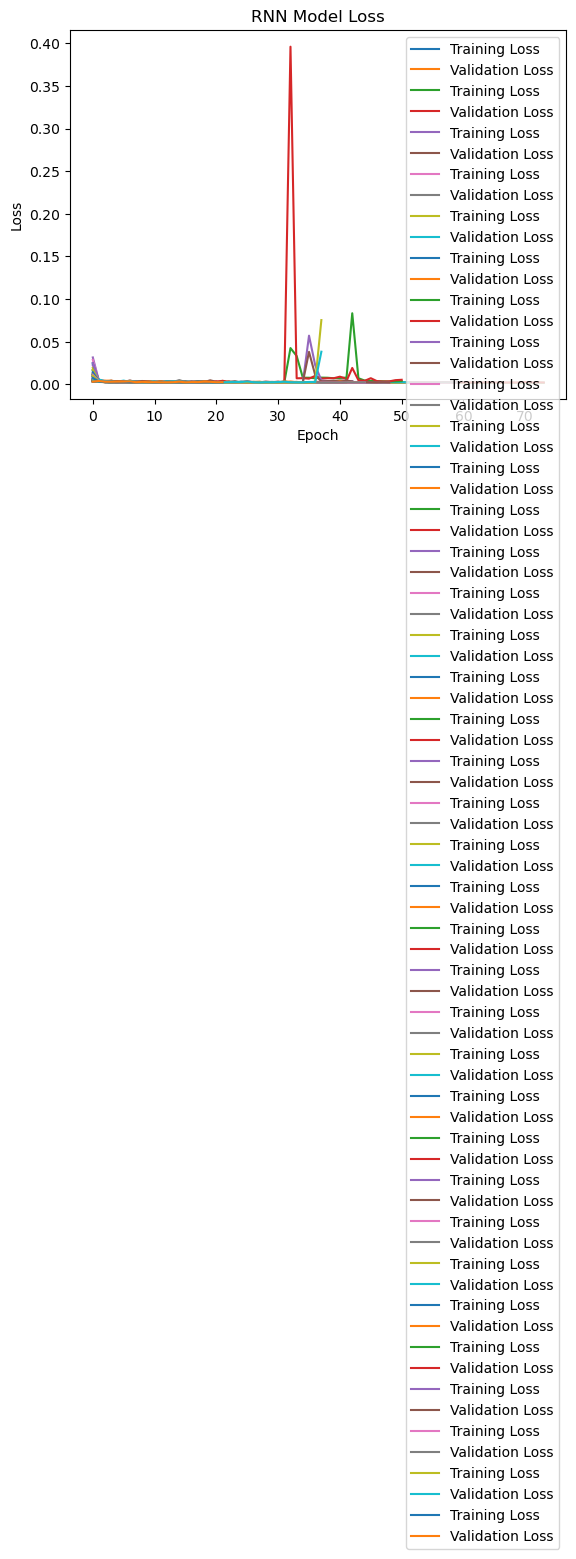

In [11]:
sequence_lengths = [10, 20, 30]
hidden_sizes = [32, 64, 128, 256]
num_layers = [1, 2, 3]
learning_rates = [0.001]

def all_in_one(features, target, sequence_length, hidden_size, num_layers, learning_rate):

    X, y = create_dataset(features, target, sequence_length)
    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.float32).to(device)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=False)

    train_dataset = CustomDataset(X_train, y_train)
    val_dataset = CustomDataset(X_val, y_val)
    test_dataset = CustomDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = EnhancedRNNModel(input_size=X.shape[2], hidden_size=hidden_size, output_size=1, num_layers=num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10, device=device)
    predictions, actuals = evaluate_model(model, test_loader, scaler_target)

    plot_performance(train_losses, val_losses, predictions, actuals, title = f'LSTM_Model_Seq_{sequence_length}_Hidden_{hidden_size}_Layers_{num_layers}_LR_{learning_rate}')
    rmse, mae = calculate_metrics(predictions, actuals)

    return rmse, mae

# Implementing grid search for hyperparameter tuning
results = []
for seq_len in sequence_lengths:
    for hidden_size in hidden_sizes:
        for num_layer in num_layers:
            for lr in learning_rates:
                print(f"Training with Seq: {seq_len}, Hidden: {hidden_size}, Layers: {num_layer}, LR: {lr}")
                rmse, mae = all_in_one(combined_features, target_scaled, seq_len, hidden_size, num_layer, lr)
                results.append((seq_len, hidden_size, num_layer, lr, rmse, mae))
                print(f"RMSE: {rmse}, MAE: {mae}")
                print("-" * 50)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results, columns=['Sequence Length', 'Hidden Size', 'Num Layers', 'Learning Rate', 'RMSE', 'MAE'])
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
